# A2 Bias In Data

## TL;DR   
The purpose of this exploration is to identify potential sources of bias in a corpus of human-annotated data, and describe some implications of those biases.

_Data Source:  https://figshare.com/projects/Wikipedia_Talk/16731_  
_Overview of the project:  https://meta.wikimedia.org/wiki/Research:Detox_  
_Overview of the data: https://meta.wikimedia.org/wiki/Research:Detox/Data_Release_

## AQUIRE DATA

Download all the data, using the `%%caption` magic keyword to suppress the outputs.

In [ ]:
%%capture  

# download toxicity data
!wget https://ndownloader.figshare.com/files/7394539 -O Raw_Data/toxicity_annotations.tsv
!wget https://ndownloader.figshare.com/files/7394542 -O Raw_Data/toxicity_annotated_comments.tsv
!wget https://ndownloader.figshare.com/files/7640581 -O Raw_Data/toxicity_worker_demographics.tsv

# download aggression data
!wget https://ndownloader.figshare.com/files/7394506 -O Raw_Data/aggression_annotations.tsv
!wget https://ndownloader.figshare.com/files/7038038 -O Raw_Data/aggression_annotated_comments.tsv
!wget https://ndownloader.figshare.com/files/7640644 -O Raw_Data/aggression_worker_demographics.tsv
     
# downlaod personal attacks
!wget https://ndownloader.figshare.com/files/7554637 -O Raw_Data/attack_annotations.tsv
!wget https://ndownloader.figshare.com/files/7554634 -O Raw_Data/attack_annotated_comments.tsv
!wget https://ndownloader.figshare.com/files/7640752 -O Raw_Data/attack_worker_demographics.tsv


Read in the downloaded data as a pandas dataframe.

In [1]:
import pandas as pd

# toxicity data
toxicity_annotations = pd.read_csv("Raw_Data/toxicity_annotations.tsv", delimiter="\t")
toxicity_annotated_comments = pd.read_csv("Raw_Data/toxicity_annotated_comments.tsv", delimiter="\t", index_col=0)
toxicity_worker_demographics = pd.read_csv("Raw_Data/toxicity_worker_demographics.tsv", delimiter="\t")

# aggression data
aggression_annotations = pd.read_csv("Raw_Data/aggression_annotations.tsv", delimiter="\t")
aggression_annotated_comments = pd.read_csv("Raw_Data/aggression_annotated_comments.tsv", delimiter="\t", index_col=0)
aggression_worker_demographics = pd.read_csv("Raw_Data/aggression_worker_demographics.tsv", delimiter="\t")

# personal attack data
attack_annotations = pd.read_csv("Raw_Data/attack_annotations.tsv", delimiter="\t")
attack_annotated_comments = pd.read_csv("Raw_Data/attack_annotated_comments.tsv", delimiter="\t", index_col=0)
attack_worker_demographics = pd.read_csv("Raw_Data/attack_worker_demographics.tsv", delimiter="\t")

## TOXICITY ANALYSIS

### EDA

First, let's look at the demographic distribution for the labelers in the toxicity dataset by building a few simple bar plots.

In [2]:
# import libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# magic code for viewing plots using jupyter notebooks:
%matplotlib inline 

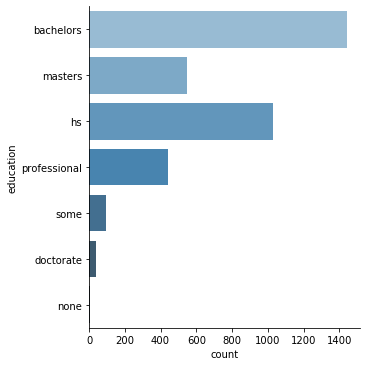

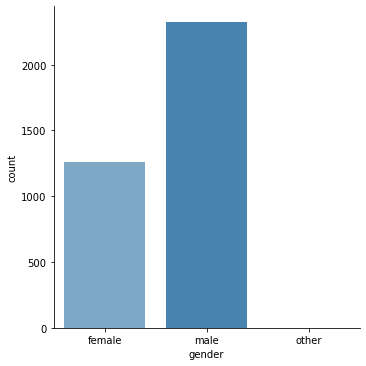

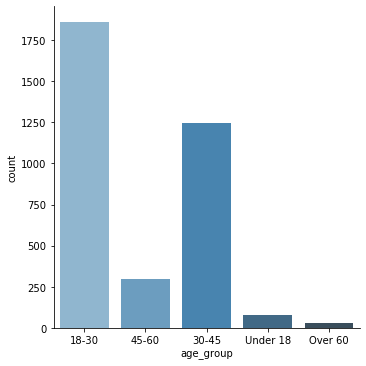

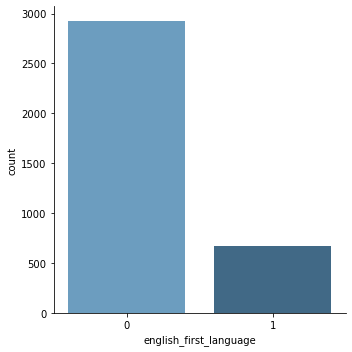

In [3]:
# plot education distribution
sns.catplot(y="education", 
            kind="count", 
            data=toxicity_worker_demographics,
            palette=("Blues"))

# plot gender dist
sns.catplot(x="gender", 
            kind="count", 
            data=toxicity_worker_demographics,
            palette=("Blues_d"))

# plot age group dist
sns.catplot(x="age_group", 
            kind="count", 
            data=toxicity_worker_demographics,
            palette=("Blues_d"))

# plot language dist
sns.catplot(x="english_first_language", 
            kind="count", 
            data=toxicity_worker_demographics,
            palette=("Blues_d"))

plt.tight_layout()

Immediately, it's clear there is quite a lot of skewed data in the demographics.  The following results become immediately apparent:
* Even though this is from english wikipedia, the vast majority of labelers are non-native English speakers.
* The majority of labelers are in the 18-30 age range.
* The majority of labelers are male.
* The majority of labelers hold a bachelors degree. 

We can combine some of this information to look for additional potential bias:

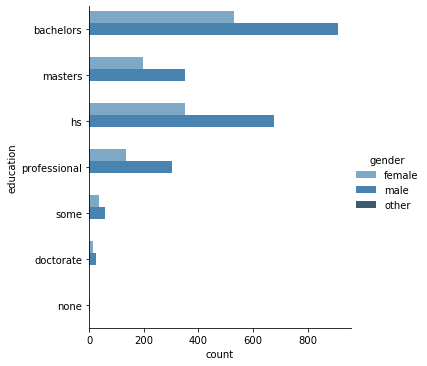

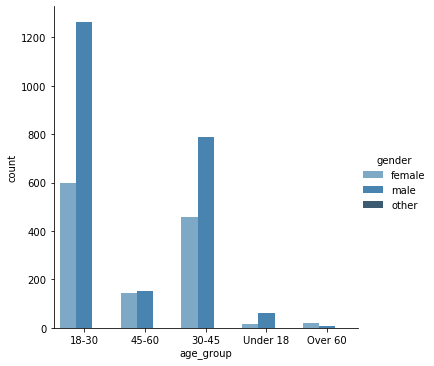

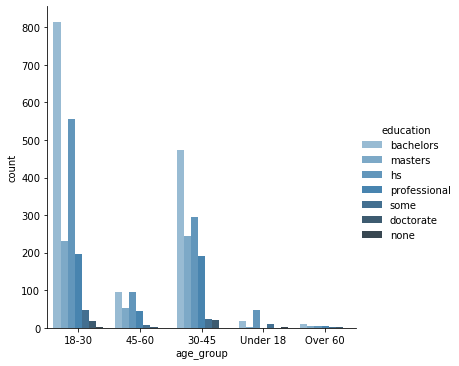

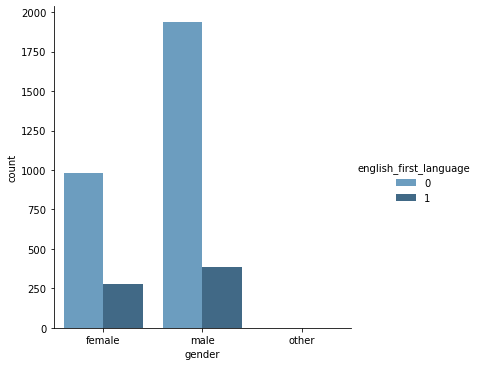

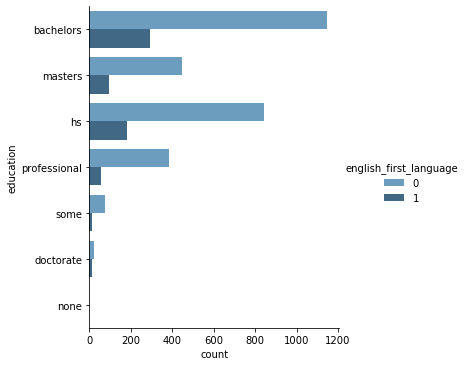

In [4]:
# plot education v. gender
sns.catplot(y="education", 
            kind="count", 
            hue = 'gender',
            data=toxicity_worker_demographics,
            palette=("Blues_d"))

# plot gender v. age
sns.catplot(x="age_group", 
            kind="count",
            hue = 'gender',
            data=toxicity_worker_demographics,
            palette=("Blues_d"))

# plot age v. education
sns.catplot(x="age_group", 
            kind="count",
            hue = 'education',
            data=toxicity_worker_demographics,
            palette=("Blues_d"))

# plot language v. gender
sns.catplot(x="gender", 
            kind="count", 
            hue = 'english_first_language',
            data=toxicity_worker_demographics,
            palette=("Blues_d"))

# plot language v. education
sns.catplot(y="education", 
            kind="count", 
            hue = 'english_first_language',
            data=toxicity_worker_demographics,
            palette=("Blues_d"))

There is clearly a lot of bias towards non-native english speaking males with a bachelor's degree in the 18-30 age group.   One intersting result here is that although there are significantly more men in the overall group, the _Over 60_ age group is biased in favor of women.  To see if the difference in demographics is evident in the labeling activity we can perform some additional analysis.  First, examine the types of columns that typically get labeled as toxic.   We'll consider a comment to be toxic if at least 50% of reviewers labeled it as such.

In [5]:
# labels a comment as toxic if the majority of annotators did so
toxicity_labels = toxicity_annotations.groupby('rev_id')['toxicity'].mean() > 0.5

# join the labels and comments
toxicity_annotated_comments['labeled_toxic'] = toxicity_labels

# remove newline and tab tokens
toxicity_annotated_comments['comment'] = toxicity_annotated_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
toxicity_annotated_comments['comment'] = toxicity_annotated_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

If we preview the results we can verify that these comments indeed appear to be toxic.

In [6]:
# preview the results
toxicity_annotated_comments.loc[toxicity_annotated_comments['labeled_toxic'] == True].head(15)

,comment,year,logged_in,ns,sample,split,labeled_toxic
rev_id,,,,,,,
597212.0,"` After the wasted bit on his sexuality, I ha...",2003,False,article,random,test,True
1266286.0,"Erik, for crying out loud. You legally can...",2003,True,user,random,test,True
1502668.0,"BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOB...",2003,True,user,blocked,test,True
2187425.0,```Nazi filth`` is impolite `,2004,True,article,random,train,True
3129678.0,"Prior to Quickpolls, he would have been perma...",2004,True,user,random,train,True
3427333.0,"Hi. Yes, I'd noticed. It's always gratifing to...",2004,True,user,random,train,True
3803199.0,"Yep, Shiguy. That's me. David Hodges. I have n...",2004,True,user,random,train,True
4282271.0,Better believe it. At least I earned a Barn...,2004,True,user,random,train,True
4632658.0,"i have a dick, its bigger than yours! hahaha",2004,False,article,blocked,train,True


We can confirm our results by quickly analyzing the words most commonly contained in these toxic comments.

In [7]:
# create a list of the 200 most common words in the comments
from collections import Counter
wordlist = Counter(" ".join(toxicity_annotated_comments.loc[toxicity_annotated_comments['labeled_toxic'] == True]['comment'].str.lower()).split()).most_common(100)

# remove common stop words from the list
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))

# add a few extra words to the stop word list
stopword_list |= set(['==', '-', '`', "I'm", 'wikipedia', 'wiki', '====', '.', 'me', 'im'])

# print the final result
for item in wordlist:
    if item[0] not in stopword_list:
        print(item)

('fuck', 8284)
('nigger', 3937)
('like', 3377)
('fucking', 3166)
('suck', 3080)
('go', 2753)
('shit', 2687)
('hate', 2586)
('u', 2528)
('faggot', 2454)
('get', 2271)
('know', 2016)
('fat', 1937)
('die', 1803)
('gay', 1767)
('moron', 1691)
('hi', 1612)
('ass', 1605)
('people', 1574)
("i'm", 1428)
('pig', 1299)
('stop', 1297)
('jew', 1292)
('one', 1288)
('penis', 1261)
('stupid', 1212)
('page', 1212)
('you,', 1203)
('think', 1173)
('sucks', 1150)
('want', 1120)
('cunt', 1037)
('cock', 1017)
('dont', 1014)


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The results are not particulary surprising.    This is the sort of langauge I would expect to find in toxic comments.   With few exceptions, most of these words do not have an alternate definitions. We can examine how these comments were treated by the labelers based on on demographic breakdowns.   Since the data is divided into three separate files, it must be joined in various ways in order to analyze.

In [8]:
# join demographics to annotations
joined_toxicity_demographics = toxicity_annotations.join(toxicity_worker_demographics, on="worker_id", rsuffix="_r")

# join comments to annotations
joined_toxicity_comments = toxicity_annotations.join(toxicity_annotated_comments, on="rev_id", rsuffix="_r")

Quickly previewing the results of each table:

In [9]:
display(joined_toxicity_demographics.head(3))
display(joined_toxicity_comments.head(3))

,rev_id,worker_id,toxicity,toxicity_score,worker_id_r,gender,english_first_language,age_group,education
0,2232.0,723,0,0.0,1789.0,male,1.0,30-45,bachelors
1,2232.0,4000,0,0.0,NaN,NaN,NaN,NaN,NaN
2,2232.0,3989,0,1.0,NaN,NaN,NaN,NaN,NaN


,rev_id,worker_id,toxicity,toxicity_score,comment,year,logged_in,ns,sample,split,labeled_toxic
0,2232.0,723,0,0.0,This: :One can make an analogy in mathematical...,2002,True,article,random,train,False
1,2232.0,4000,0,0.0,This: :One can make an analogy in mathematical...,2002,True,article,random,train,False
2,2232.0,3989,0,1.0,This: :One can make an analogy in mathematical...,2002,True,article,random,train,False


We can calculate a mean toxicity score for each individual and add that to the demographics table.

In [10]:
# calculate average toxicity per user
avg_worker_toxicity = joined_toxicity_demographics.groupby("worker_id")["toxicity_score"].mean()

# join the average toxicity to the demographics table
toxicity_worker_demographics = toxicity_worker_demographics.join( avg_worker_toxicity )

# preview the results
toxicity_worker_demographics.head()

,worker_id,gender,english_first_language,age_group,education,toxicity_score
0,85,female,0,18-30,bachelors,-0.208768
1,1617,female,0,45-60,bachelors,0.000000
2,1394,female,0,NaN,bachelors,0.258403
3,311,male,0,30-45,bachelors,0.689373
4,1980,male,0,45-60,masters,-0.105263


There is quite a bias in the toxicity score by age group.   This becomes more apparent in graph form.   There is appears to be a direct linear relationship between age and the average toxicity score.

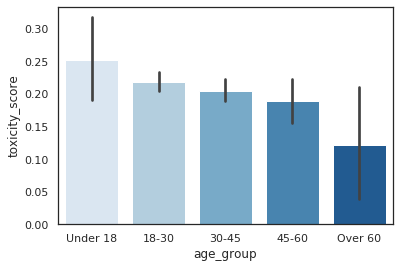

In [37]:
# create barplot, specify the order
sns.barplot(x="age_group", 
                 y="toxicity_score", 
                 data=toxicity_worker_demographics, 
                 order=["Under 18", "18-30", "30-45", "45-60", "Over 60"],
                palette=("Blues"))

However, the scoring is much more uniform across the other demographic groups (education, language, and gender).   

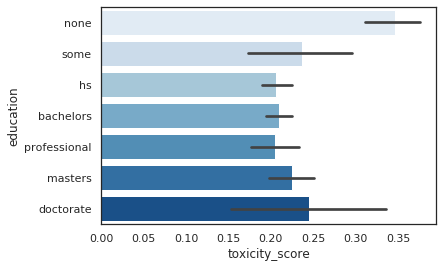

In [38]:
# create barplot, specify the order
sns.barplot(y="education", 
                 x="toxicity_score", 
                 data=toxicity_worker_demographics, 
                 order=["none", "some", "hs", "bachelors", "professional", "masters", "doctorate"],
                 palette=("Blues"))

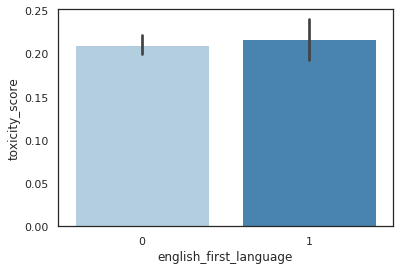

In [39]:
# create barplot, specify the order
sns.barplot(x="english_first_language", 
                 y="toxicity_score", 
                 data=toxicity_worker_demographics, 
                 palette=("Blues"))

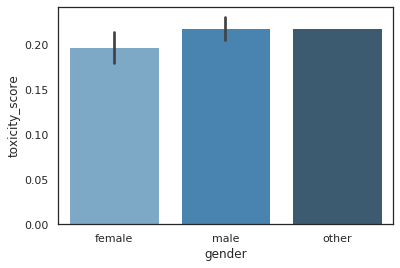

In [31]:
# create barplot, specify the order
sns.barplot(x="gender", 
                 y="toxicity_score", 
                 data=toxicity_worker_demographics, 
                 palette=("Blues_d"))

The most dramatic difference in scoring appears to be from individuals in the over 60 group.  Here, the variation is quite high.

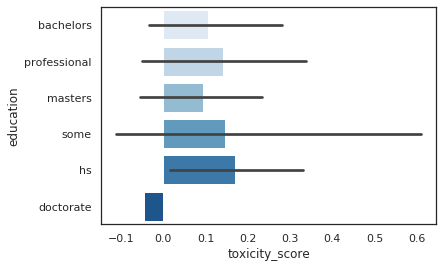

In [55]:
sns.barplot(x="toxicity_score", 
                 y="education", 
                 data=toxicity_worker_demographics.loc[toxicity_worker_demographics['age_group'] == "Over 60"], 
                 palette=("Blues"))

### ATTACK EDA

### PERSONAL ATTACK ANALYSIS

We can now repeat a similar analysis for the `personal attacks` dataset.

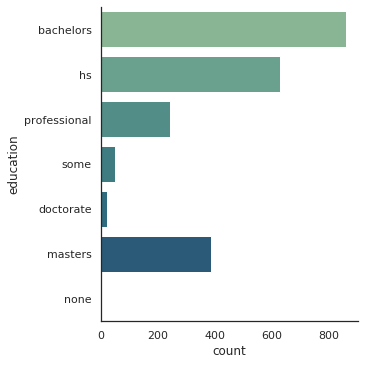

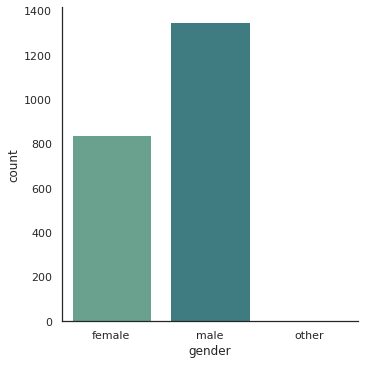

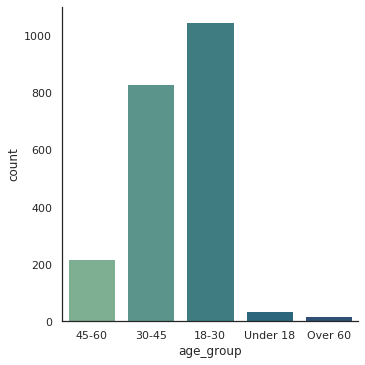

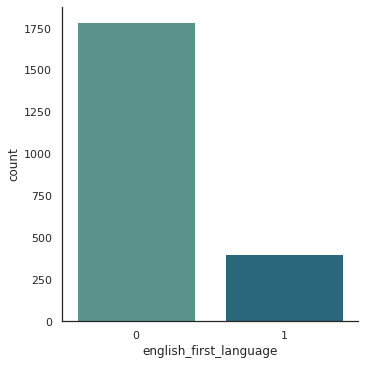

In [60]:
# plot education distribution
sns.catplot(y="education", 
            kind="count", 
            data=attack_worker_demographics,
            palette=("crest"))

# plot gender dist
sns.catplot(x="gender", 
            kind="count", 
            data=attack_worker_demographics,
            palette=("crest"))

# plot age group dist
sns.catplot(x="age_group", 
            kind="count", 
            data=attack_worker_demographics,
            palette=("crest"))

# plot language dist
sns.catplot(x="english_first_language", 
            kind="count", 
            data=attack_worker_demographics,
            palette=("crest"))


Here again, we see similiar issues to the toxicity dataset.   It appears as though the same group of individuals was responsible for categorizing these comments as well.

In [62]:
# labels a comment as toxic if the majority of annotators did so
attack_labels = attack_annotations.groupby('rev_id')['attack'].mean() > 0.5

# join the labels and comments
attack_annotated_comments['labeled_attack'] = attack_labels

# remove newline and tab tokens
attack_annotated_comments['comment'] = attack_annotated_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
attack_annotated_comments['comment'] = attack_annotated_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [63]:
# preview the results
toxicity_annotated_comments.loc[toxicity_annotated_comments['labeled_toxic'] == True].head(15)

,comment,year,logged_in,ns,sample,split,labeled_toxic
rev_id,,,,,,,
597212.0,"` After the wasted bit on his sexuality, I ha...",2003,False,article,random,test,True
1266286.0,"Erik, for crying out loud. You legally can...",2003,True,user,random,test,True
1502668.0,"BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOB...",2003,True,user,blocked,test,True
2187425.0,```Nazi filth`` is impolite `,2004,True,article,random,train,True
3129678.0,"Prior to Quickpolls, he would have been perma...",2004,True,user,random,train,True
3427333.0,"Hi. Yes, I'd noticed. It's always gratifing to...",2004,True,user,random,train,True
3803199.0,"Yep, Shiguy. That's me. David Hodges. I have n...",2004,True,user,random,train,True
4282271.0,Better believe it. At least I earned a Barn...,2004,True,user,random,train,True
4632658.0,"i have a dick, its bigger than yours! hahaha",2004,False,article,blocked,train,True


Join the dataframes from similar datasets in order to analyze as a whole.

In [ ]:
joined_toxicity_annotations = toxicity_annotations.join(toxicity_worker_demographics, on="worker_id", rsuffix="_r")
joined_aggression_annotations = aggression_annotations.join(aggression_worker_demographics, on="worker_id", rsuffix="_r")
joined_attack_annotations = attack_annotations.join(attack_worker_demographics, on="worker_id", rsuffix="_r")

In [ ]:
joined_toxicity_annotations = toxicity_annotations.join(toxicity_annotated_comments, on="rev_id", rsuffix="_r")


In [ ]:

# labels a comment as an atack if the majority of annoatators did so
labels = attack_annotations.groupby('rev_id')['attack'].mean() > 0.5

In [ ]:

# join labels and comments
attack_annotated_comments['attack'] = labels

In [ ]:
# remove newline and tab tokens
attack_annotated_comments['comment'] = attack_annotated_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
attack_annotated_comments['comment'] = attack_annotated_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

attack_annotated_comments.loc[attack_annotated_comments['attack'] == True]

Preview the results.

In [ ]:
joined_toxicity_annotations.head()

## Analysis / Visualization

Calculate the average score per worker - that worker's "toxicity bias". Is this different for different age groups?

In [ ]:
avg_worker_toxicity = joined_toxicity_annotations.groupby("worker_id")["toxicity_score"].mean()
toxicity_worker_demographics = toxicity_worker_demographics.join(avg_worker_toxicity)
toxicity_worker_demographics.head()


Now let's compute an average toxicity statistic for each group...

In [ ]:
toxicity_worker_demographics.groupby("age_group").toxicity_score.mean()

## Implications

### 

---

In [ ]:
# requires plotly install
# conda install -c anaconda plotly
import plotly.express as px



# also needs ipython widgets
conda install jupyterlab "ipywidgets=7.5"


# JupyterLab renderer support
jupyter labextension install jupyterlab-plotly@4.11.0

jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.11.0

In [ ]:
import plotly.graph_objects as go
fig = go.FigureWidget(data=go.Bar(y=[2, 3, 1]))
fig

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
fig.write_html('second_figure.html', auto_open=True)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
fig.show()

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt